# The SPHERE Challenge: Activity Recognition with Multimodal Sensor Data



<div class="alert alert-info"><em>This is a guest post by Niall Twomey of the SPHERE project's machine learning team — enjoy!</em></div>

Welcome to the SPHERE Challenge! We are very excited to be working with [DrivenData](http://www.drivendata.org), the [ECML-PKDD](http://www.ecmlpkdd2016.org) conference and the [AARP](http://www.aarp.org/aarp-foundation/) foundation with this challenge! 

My name is [Niall Twomey](http://www.irc-sphere.ac.uk/uob-niall), and I am a postdoctoral researcher on the machine learning with the [SPHERE](http://www.irc-sphere.ac.uk) project. In this post I'm going to first walk you through how to work with the data we provide, and then I'm going to provide an implmentation of a baseline classification algorithm. This baseline isn't by any means going to win the challenge :-) but it will show you how you can work with the data, as there is a bit of work needed to transform the raw data in the tabular formats that we are most familiar with in maching learning problems. 

There are four main sections in this post: 

1. I will start by visualising of all of the data modalities (a crucial initial step in all prediction problems!); 
2. Then I will extract very simple features from all of the sensor modalities. 
3. Due to the data collection system, we will need to deal with missing data with data imputation; and 
4. Finally after we get the data into a nice tabular format, we will test a k-nearest neighbour based classifier on the test data. 

I hope this is helpful! 

Time to start! :-)

In [9]:
from __future__ import print_function

# For number crunching
import numpy as np
import pandas as pd

# For visualisation
import matplotlib.pyplot as pl 
import seaborn as sns 

# For prediction 
import sklearn

# Misc
from itertools import cycle
import json 
import os

# Magic and formatting
# % matplotlib inline

sns.set_context('poster')
sns.set_style('darkgrid')

current_palette = cycle(sns.color_palette())

# Module versions

    These are the library versions we worked with to produce our results. 

In [10]:
print('  numpy version: {}'.format(np.__version__))
print(' pandas version: {}'.format(pd.__version__))
print('seaborn version: {}'.format(sns.__version__))
print('   json version: {}'.format(json.__version__))
print('sklearn version: {}'.format(sklearn.__version__))

  numpy version: 1.19.3
 pandas version: 1.1.4
seaborn version: 0.11.0
   json version: 2.0.9
sklearn version: 0.23.2


# Visualisation

Before doing any prediction, I think it will be helpful to do visualisation on the data itself. To do this, we will use a set of classes that we wrote for easy access to the data. These are stored in a Python file called `visualise_data.py` (available [here](https://gist.github.com/drivendata/27b1c600239d1a33d173f88ea4ef2231)) and are quite interpretable. 

We will visualise the training sequence identified by `00001`. This is an arbitrary selection, and the cells below will work on all records (though if visualising the test instances the ground truth won't be shown, of course). 

The structure of the public data download is shown below.

```
├── public_data
│   ├── accelerometer_axes.json
│   ├── access_point_names.json
│   ├── annotations.json
│   ├── pir_locations.json
│   ├── rooms.json
│   ├── sample_submission.csv
│   ├── train
│   │   ├── 00001
│   │   ├── ...
│   │   └── 00010
│   ├── test
│   │   ├── 00011
│   │   ├── ...
│   │   └── 00882
│   ├── video_feature_names.json
│   └── video_locations.json
```

We use a helper class called `SequenceVisualisation` that can be located in the `visualise_data.py` file. This class will load in all of the available data, let you slice training data by activity, will plot some of the sensor data and annotations (when they are available), amongst other super useful things! 

We use three main sensor types in this challenge: PIR sensors, accelerometers, and video. We will show you what those data look like in this first, then show how you might perform feature extraction on the data, and finally we will then show how you might classify data! 

In [11]:
# Add the parent folder to PYTHONPATH (sys.path)
import sys
nb_dir = os.path.split(os.getcwd())
nb_dir2 = nb_dir[0]+'/'+nb_dir[1]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
if nb_dir2 not in sys.path:
    sys.path.append(nb_dir2)
    
# public_data_path = '/Users/fl20994/Documents/IAI_CDT/TB2/Applied_Data_Science/SPHERE/public_data' 
# public_data_path = '../public_data'
public_data_path = nb_dir2+'/data' # 

# metadata_path = '/Users/fl20994/Documents/IAI_CDT/TB2/Applied_Data_Science/SPHERE/public_data/metadata'
# metadata_path = '../public_data/metadata'
metadata_path = nb_dir2+'/data/metadata'

print(metadata_path)
    
from visualise_data import SequenceVisualisation

plotter = SequenceVisualisation(metadata_path, public_data_path + '/train/00001')

sequence_window = (plotter.meta['start'], plotter.meta['end'])

# We can extract the time range of the activity 'jump' with the 'times_of_activity' function. 
# This function returns all of the times that jump was annotated, and it is indexed first 
# by the annotator, and then by the time at which it occurred. 
times_of_jump = plotter.times_of_activity('a_jump')

# You can get the times at which these. 
for ai, annotator_jumps in enumerate(times_of_jump): 
    print ('Annotator {}'.format(ai))
    
    # The annotator_jumps is a list of tuples. The length of this list specifies the number of segments as
    # annotated as 'a_jump' by this annotator. Each element of this list is a tuple that holds the start and 
    # end time of the t-th annotation in that order, ie: 
    for ti, (start, end) in enumerate(annotator_jumps, start=1): 
        print ('  Annotation {}'.format(ti))
        print ('    Start time: {}'.format(start))
        print ('    End time:   {}'.format(end))
        print ('    Duration:   {}'.format(end - start))
        print ()

# The sequence object also holds metadata regarding the length of the sequence. 
sequence_window = (plotter.meta['start'], plotter.meta['end'])
print (sequence_window)

C:\Users\amarp\OneDrive\Desktop\latest\Sep 2019 onwards ML\Bristol\Interactive AI CDT\Applied Data Science\Group Project\Sphere-main/Sphere-main/data/metadata
Annotator 0
  Annotation 1
    Start time: 1775.6870000000001
    End time:   1776.348
    Duration:   0.6609999999998308

  Annotation 2
    Start time: 1776.901
    End time:   1777.87
    Duration:   0.9689999999998236

Annotator 1
  Annotation 1
    Start time: 1774.974
    End time:   1778.844
    Duration:   3.8700000000001182

(0, 1823.9170000000001)


# Plotting location. 

The black lines in the image below are the times during which the PIR sensors were activated. The red, green, and blue lines here are then the annotations provided by the three annotators. 

Note PIR sensors can elicit false negative and false positive activations - ie they do not always trigger when someone is present, and they can trigger when someone is not present due to the infrared radiation from the sun in warm weather. 

In this challenge, evaluation does not consider prediction of location, but knowing the location will help in classification performance, eg someone on the staircase is more likely to be ascending/descending the stairs rather than walking flat, and they would be very unlikely to be sitting. Location information is provided in the training data sets only. 

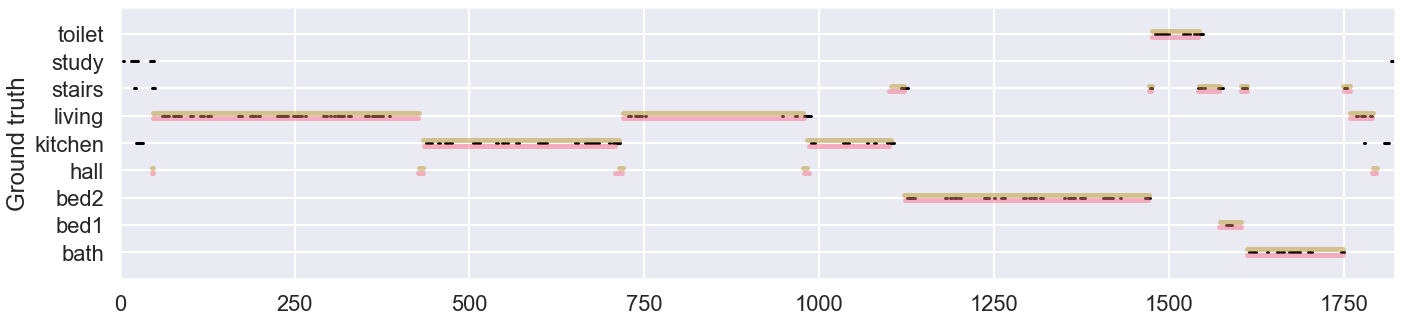

In [12]:
plotter.plot_pir(sequence_window, sharey=True)

# Plotting RSSI. 

This function plots the received signal strength indicator (RSSI) of the wireless transmission. RSSI is a measure of how strongly the accelerometer's signal was received. As a simple rule, the closer you are to the receiver (which we call an `access point`), the more power there is in the received signal (but this rule doesn't necessarily apply if your body gets in the way of the accelerometer and the access point!).

There are four access points located in the SPHERE house, and these are located in: 

1. the kitchen; 
2. the loung; 
3. upstairs; and 
4. in the study. 

RSSI is a useful indication of location (together with PIR data). In the image below, the RSSI data is plotted together with the locations. There is a very strong correspondance, for example, between the lounge trace (green) and the annotation of presence in the lounge. And in locations without an access point (eg `bed2`) you can see patterns in the RSSI signal that should be indicative of your location. 

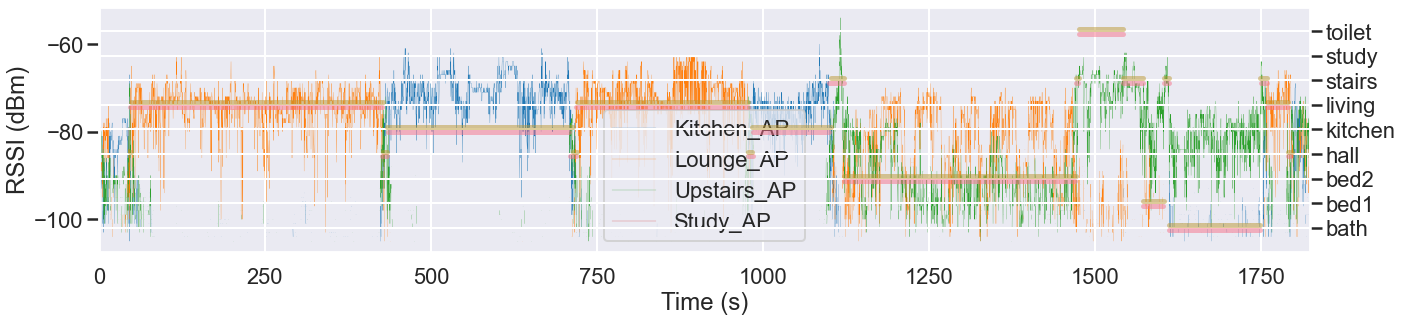

In [13]:
plotter.plot_rssi(sequence_window)

# Plotting acceleration. 

This plots the acceleration data (in the continuous line traces) and annotated activities. 

Here we can see another interesting aspect of the data, namely that while the annotators agree quite a lot of the time, often there is disagreement regarding the annotated activities. There are various different types of disagreement, and one of the most interesting is the disagreement of the specific start and end times of the activities. 

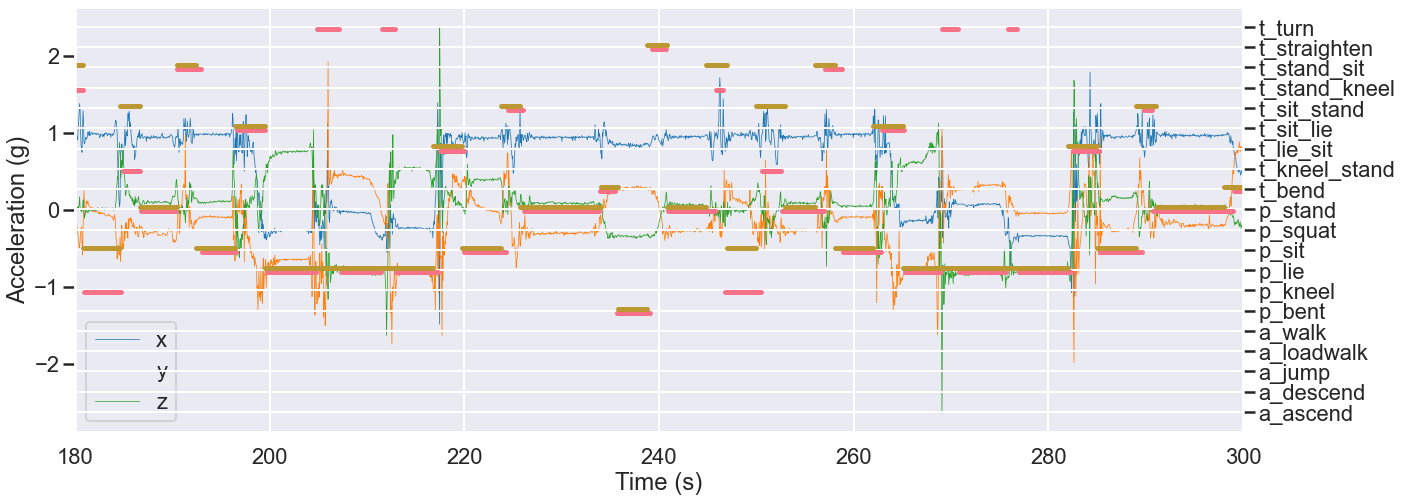

In [14]:
plotter.plot_acceleration((sequence_window[0] + 180, sequence_window[0] + 300))

# Plotting video data. 

The visualisation below shows the video data that we give with this challenge. We do not give the raw video data (in order to procet the anonymity of the participants), so we give coordinate of 2D and 3D bounding boxes, and the centre of these boxes. These are quite coarse as features go, but there is certainly valuable information in the features that you might extract from these bounding boxes (including volumn, height, aspect ratios, etc). To understand what all of the columns are, see §2.2 from the following paper: 

> Niall Twomey, Tom Diethe, Meelis Kull, Hao Song, Massimo Camplani, Sion Hannuna, Xenofon Fafoutis, Ni Zhu, Pete Woznowski, Peter Flach, Ian Craddock: *“The SPHERE Challenge: Activity Recognition with Multimodal Sensor Data”*, 2016;arXiv:1603.00797.

In the images below, we plot the the centre of the 2D and 3D bounding boxes. The cameras are located in the `hallway`, `living_room` and the `kitchen` respectively. The red, blue and green horozontal lines in the images correspond to the ground truth location annotations that are provided, and these correspond to the right hand axis labels. eg, at 500 seconds, the annotations state that the participant was in the kitchen. The other lines indicate the values of the features as the participant moves throughout the room. 

Text(0.5, 0.98, '3D bounding box')

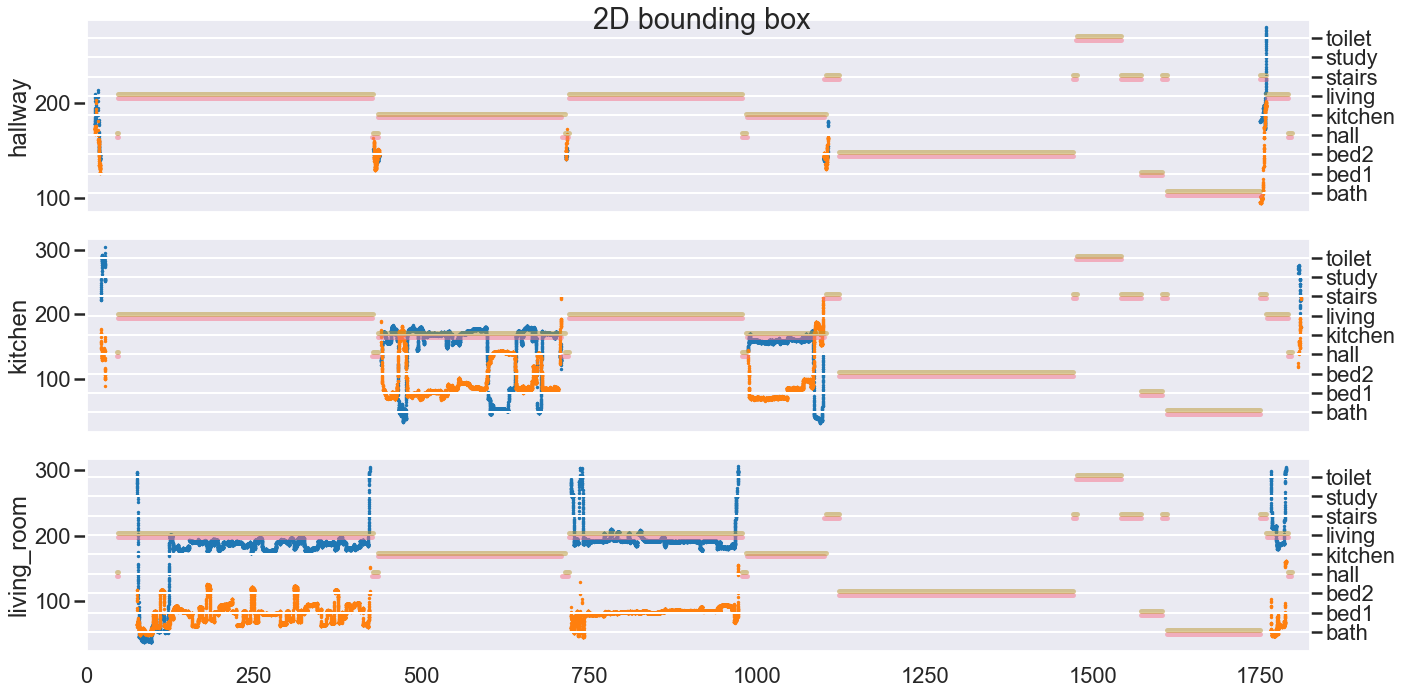

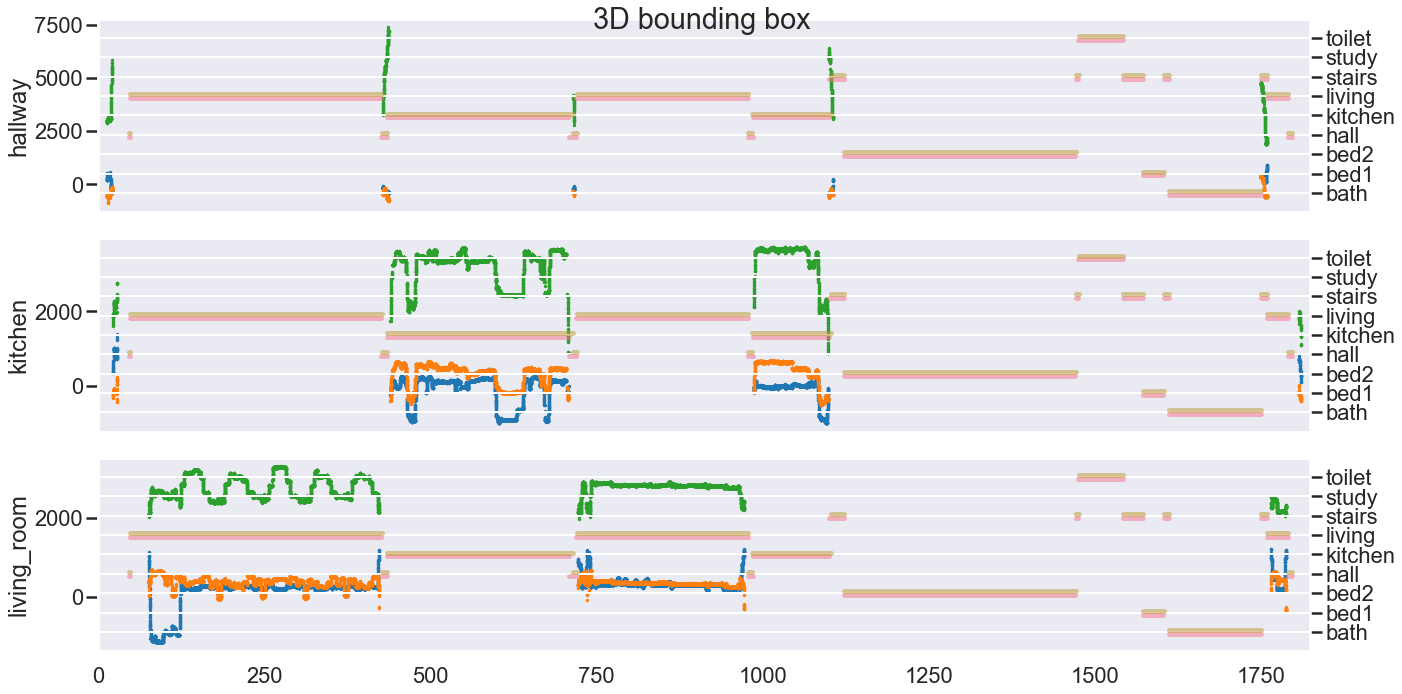

In [15]:
plotter.plot_video(plotter.centre_2d, sequence_window)
pl.gcf().suptitle('2D bounding box')

plotter.plot_video(plotter.centre_3d, sequence_window)
pl.gcf().suptitle('3D bounding box')

# Visualising the classification targets 

We now take a look at the ground truth targets that accompany the training sequences. The labels that are annotated (20 in total) are described in the main page. In the image below, we plot the first two minutes of the target data. In the image, the x-axis is over time, and the y-axis is over probabilities. Each subplot represents a particular activity, and we only plot the activities which have been annotated over this time window so as to save vertical space. 

One of the most important things to take away from this image is that the targets are not 0/1, but they are probabilities, and the probilities represent the average label assigned by the annotators. 

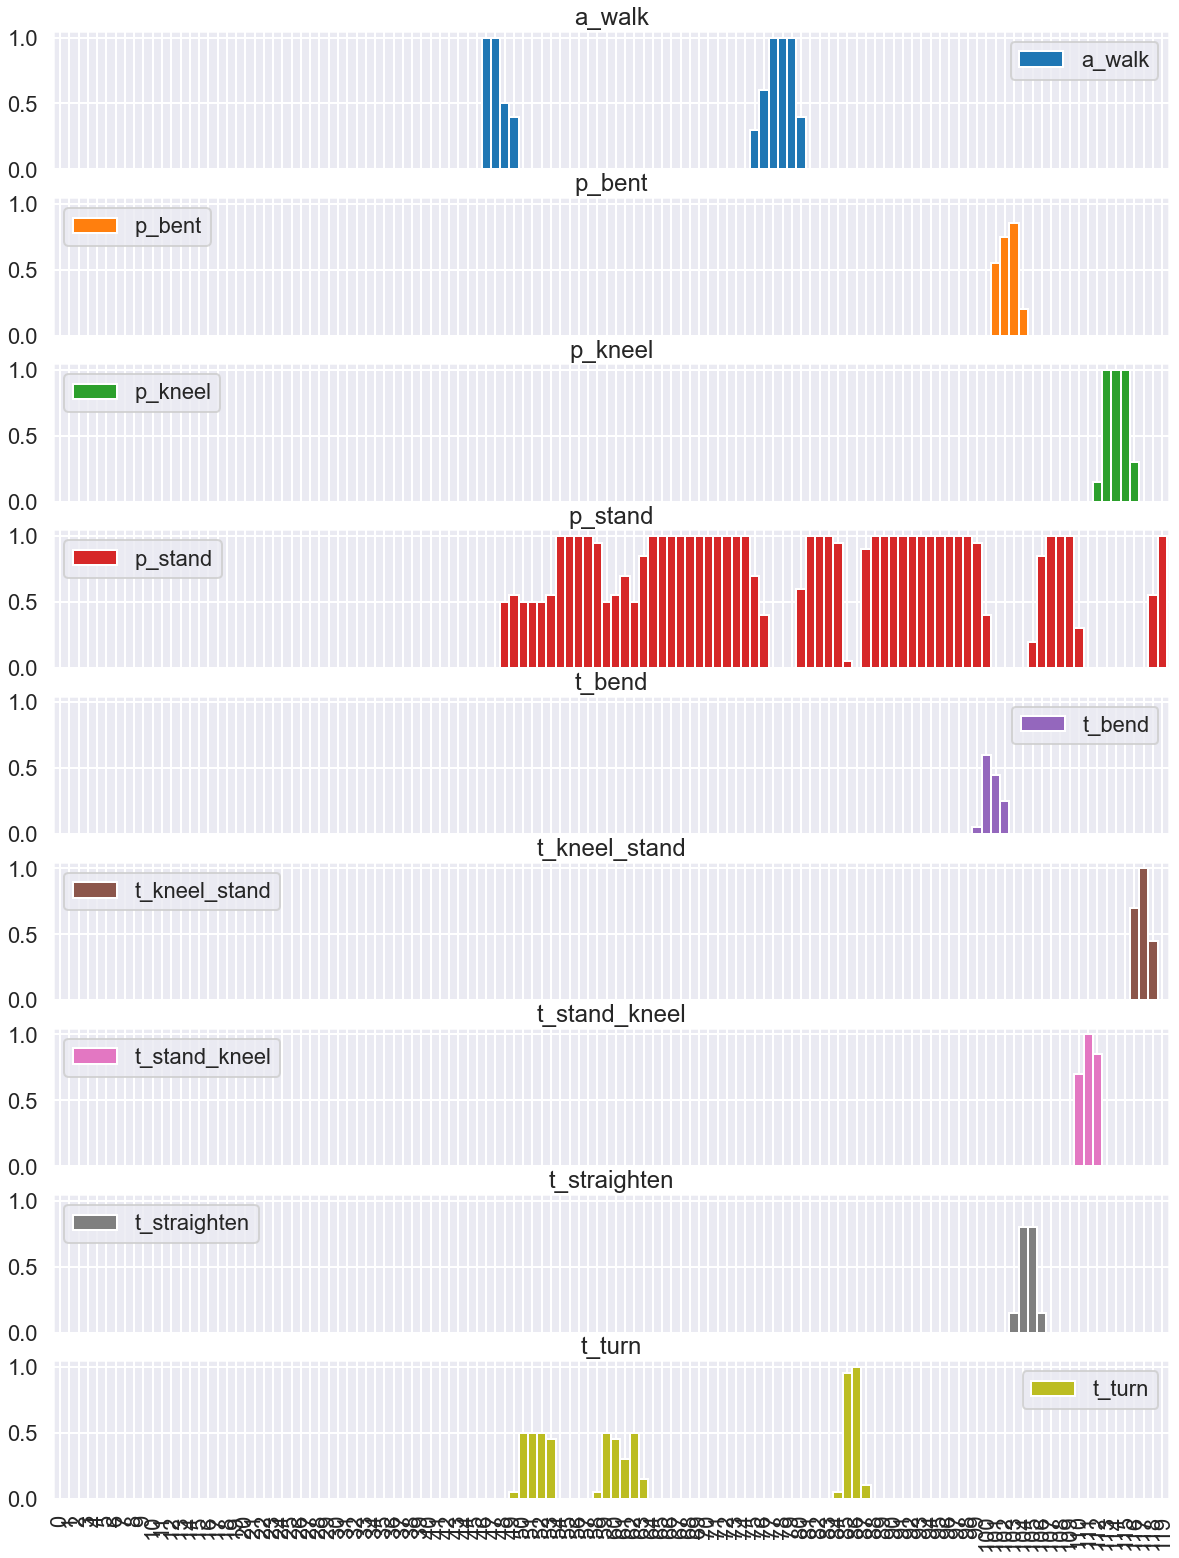

In [16]:
annotation_names = plotter.targets.columns.difference(['start', 'end'])

# Select only the first minute of data 
sub_df = plotter.targets.iloc[:60 * 2]

# Select only the columns that are non-empty 
sub_df_cols = [col for col in annotation_names if sub_df[col].sum() > 0]

# Plot a bar-plot w
current_palette = cycle(sns.color_palette())
sub_df[sub_df_cols].plot(
    kind='bar', 
    subplots=True, 
    sharex=True, 
    sharey=True, 
    figsize=(20, 3 * len(sub_df_cols)), 
    width=1.0, 
    color=[next(current_palette) for _ in annotation_names]
);

# Extracting Features

Now that we understand the data and the classification targets better, it's time to do some feature extraction. We have intentionally given the data in a very raw state so that the participants of the challenge are free to do as much feature engineering (or feature modelling!) as possible. So, there is a bit of work that needs to be done in order to get the data into a standard tabular format that you would expect to see in a classification task. 

One useful member function in the `Sequence` class from the `visualise_data.py` file is `iterate`. This is a function that iterates through all of the data in the sequence one second at a time, and it returns pandas dataframes for each sensor modality (environmental, accelerometer, video), and we extract features from these dataframes. 

In this cell, we will extract very simple features from each modalitiy, namely the mean, standard deviation, minimum, median, and maxiumum values of all of the sensors. These are very simple features, and not all of them really make sense for all modalities, but this is just a baseline afterall! 

In [17]:
from visualise_data import Sequence

import warnings
warnings.filterwarnings('ignore')

"""
For every data modality, we will extract some very simple features: the mean, min, max, median, and standard 
deviation of one second windows. We will put function pointers in a list called 'feature_functions' so that we 
can easily call these on our data for later
"""
feature_functions = [np.mean, np.std, np.min, np.median, np.max, np.sum]
feature_names = ['mean', 'std', 'min', 'median', 'max', 'sum']

# We will keep the number of extracted feature functions as a parameter 
num_ff = len(feature_functions)

# We will want to keep track of the feature names for later, so we will collect these in the following list: 
column_names = []

# These are the modalities that are available in the dataset, and the .iterate() function returns the data 
# in this order
modality_names = ['acceleration', 'rssi', 'pir', 'video_living_room', 'video_kitchen', 'video_hallway']

"""
Iterate over all training directories
"""
for train_test in (['train']):#, 'test', ): 
    if train_test is 'train': 
        print ('Extracting features from training data.\n')
    else: 
        print ('\n\n\nExtracting features from testing data.\n')
        
    for fi, file_id in enumerate(os.listdir('{}/{}/'.format(public_data_path, train_test))):

        if ".DS_Store" in str(file_id):
            continue

        stub_name = str(file_id).zfill(5)
        


        if train_test is 'train' or np.mod(fi, 50) == 0:
            print ("Starting feature extraction for {}/{}".format(train_test, stub_name))

        # Use the sequence loader to load the data from the directory. 
        data = Sequence(metadata_path, '{}/{}/{}'.format(public_data_path, train_test, stub_name))
        data.load()

        """
        Populate the column_name list here. This needs to only be done on the first iteration
        because the column names will be the same between datasets. 
        """
        if len(column_names) == 0:
            for lu, modalities in data.iterate():#(ms=1000):
                for modality, modality_name in zip(modalities, modality_names):
                    for column_name, column_data in modality.transpose().iterrows():
                        for feature_name in feature_names:
                            column_names.append('{0}_{1}_{2}'.format(modality_name, column_name, feature_name))

                # Break here 
                break 

        """
        Here, we will extract some features from the data. We will use the Sequence.iterate function. 

        This function partitions the data into one-second dataframes for the full data sequence. The first element 
        (which we call lu) represents the lower and upper times of the sliding window, and the second is a list of
        dataframes, one for each modality. The dataframes may be empty (due to missing data), and feature extraction 
        has to be able to cope with this! 

        The list rows will store the features extracted for this dataset
        """
        rows = []

        for ri, (lu, modalities) in enumerate(data.iterate()): #(ms=1000)):
            row = []

            """
            Iterate over the sensing modalities. The order is given in modality_names. 

            Note: If you want to treat each modality differently, you can do the following: 

            for ri, (lu, (accel, rssi, pir, vid_lr, vid_k, vid_h)) in enumerate(data.iterate()):
                row.extend(extract_accel(accel))
                row.extend(extract_rssi(rssi))
                row.extend(extract_pir(pir))
                row.extend(extract_video(vid_lr, vid_k, vid_h))

            where the extract_accel/extract_rssi/extract_pir/extract_video functions are designed by you. 
            In the case here, we extract the same features from each modality, but optimal performance will 
            probably be achieved by considering different features for each modality. 
            """

            for modality in modalities:
                """
                The accelerometer dataframe, for example, has three columns: x, y, and z. We want to extract features 
                from all of these, and so we iterate over the columns here. 
                """
                for name, column_data in modality.transpose().iterrows():
                    if len(column_data) > 3:
                        """
                        Extract the features stored in feature_functions on the column data if there is sufficient 
                        data in the dataframe. 
                        """
                        row.extend(map(lambda ff: ff(column_data), feature_functions))

                    else:
                        """
                        If no data is available, put nan placeholders to keep the column widths consistent
                        """
                        row.extend([np.nan] * num_ff)

            # Do a quick sanity check to ensure that the feature names and number of extracted features match
            assert len(row) == len(column_names)

            # Append the row to the full set of features
            rows.append(row)

            # Report progress 
            if train_test is 'train':
                if np.mod(ri + 1, 50) == 0:
                    print ("{:5}".format(str(ri + 1))),

                if np.mod(ri + 1, 500) == 0:
                    print

        """
        At this stage we have extracted a bunch of simple features from the data. In real implementation, 
        it would be advisable to look at more interesting features, eg

          * acceleration: link
          * environmental: link
          * video: link

        We will save these features to a new file called 'columns.csv' for use later. This file will be located 
        in the name of the training sequence. 
        """
        df = pd.DataFrame(rows)
        df.columns = column_names
        df.to_csv('{}/{}/{}/columns_1000ms.csv'.format(public_data_path, train_test, stub_name), index=False)

        if train_test is 'train' or np.mod(fi, 50) == 0:
            if train_test is 'train': 
                print ("Finished feature extraction for {}/{}\n".format(train_test, stub_name))

Extracting features from training data.

Starting feature extraction for train/00001
50   
100  
150  
200  
250  
300  
350  
400  
450  
500  
550  
600  
650  
700  
750  
800  
850  
900  
950  
1000 
1050 
1100 
1150 
1200 
1250 
1300 
1350 
1400 
1450 
1500 
1550 
1600 
1650 
1700 
1750 
1800 
Finished feature extraction for train/00001

Starting feature extraction for train/00002
50   
100  
150  
200  
250  
300  
350  
400  
450  
500  
550  
600  
650  
700  
750  
800  
850  
900  
950  
1000 
1050 
1100 
1150 
1200 
1250 
1300 
1350 
1400 
1450 
1500 
1550 
1600 
1650 
Finished feature extraction for train/00002

Starting feature extraction for train/00003
50   
100  
150  
200  
250  
300  
350  
400  
450  
500  
550  
600  
650  
700  
750  
800  
850  
900  
950  
1000 
1050 
1100 
1150 
1200 
1250 
1300 
1350 
1400 
1450 
1500 
1550 
1600 
Finished feature extraction for train/00003

Starting feature extraction for train/00004
50   
100  
150  
200  
250  
300  
350  


In [18]:
df.head(3)

,acceleration_x_mean,acceleration_x_std,acceleration_x_min,acceleration_x_median,acceleration_x_max,acceleration_x_sum,acceleration_y_mean,acceleration_y_std,acceleration_y_min,acceleration_y_median,...,video_hallway_bb_3d_flt_y_min,video_hallway_bb_3d_flt_y_median,video_hallway_bb_3d_flt_y_max,video_hallway_bb_3d_flt_y_sum,video_hallway_bb_3d_flt_z_mean,video_hallway_bb_3d_flt_z_std,video_hallway_bb_3d_flt_z_min,video_hallway_bb_3d_flt_z_median,video_hallway_bb_3d_flt_z_max,video_hallway_bb_3d_flt_z_sum
0,-0.8919,0.006617,-0.904,-0.890,-0.874,-17.838,0.2341,0.007654,0.216,0.237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.8927,0.007597,-0.910,-0.894,-0.880,-17.854,0.2308,0.020252,0.206,0.227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.8941,0.006340,-0.904,-0.895,-0.882,-17.882,0.2398,0.021409,0.214,0.238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Extraction

Now that we have a simple tabular set of features on hand, we can do some machine learning! 

## Things to consider
There are a number of things that we will need to keep in mind: 

1. we have missing data: we will handle this problem by imputing the mean column values with sklearn.preprocessing.Imputer class. In general you might want to be cleaverer than this. 
2. the labels are probabilistic: this means that the targets are not just 0 and 1 because the labels are averaged over multiple annotators, and as we saw from the data visualisations, they do not always agree! 

## The selected model 
To make predictions we will use a very simple model. First, we will partition the data into training and testing sets. Secondly, we will learn a k-nearest neighbours (KNN) model on the training features. To predict with new test instances, then, we will select the neighbours from the training set that are nearest to the new instance, and the label we predict is the average label from those training instances. 

# Preliminaries: data imputation

In [19]:
"""
We will define two convenience function to load the extracted features and their 
"""


def load_sequence(file_id):
    filename = str(file_id).zfill(5) # zfill fills with 5 zeros at the beginning of the string

    df = pd.read_csv('{}/train/{}/columns_1000ms.csv'.format(public_data_path, filename))
    data = df.values
    target = np.asarray(pd.read_csv('{}/train/{}/targets.csv'.format(public_data_path, filename)))[:, 2:]

    return data, target


def load_sequences(file_ids):
    x_es = []
    y_es = []

    for file_id in file_ids:
        data, target = load_sequence(file_id)

        x_es.append(data)
        y_es.append(target)

    return np.row_stack(x_es), np.row_stack(y_es)



In [20]:
# Load the training and testing data - all from the train directory(?)
# The functions above grab the dataframes from each of the train directories and combine them together. (The dfs in those directories are themselves combinations of the data from the different modalities)
train_x, train_y = load_sequences([1, 2, 3, 4, 5, 6, 7, 8])
test_x, test_y = load_sequences([9, 10])

In [21]:

print ("Check whether the train/test features are all finite (before imputation)")
print ('All training data finite:', np.all(np.isfinite(train_x)))
print ('All testing data finite:', np.all(np.isfinite(test_x)))
print 

# We will want to impute the missing data 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
imputer.fit(train_x)

train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

print ("Check whether the train/test features are all finite (after imputation)")
print ('All training data finite:', np.all(np.isfinite(train_x)))
print ('All testing data finite:', np.all(np.isfinite(test_x)))
print 

# Load the label names 
labels = json.load(open(metadata_path + '/annotations.json'))
n_classes = len(labels)

"""
Note, not all data is annotated, so we select only the annotated rows
"""
train_y_has_annotation = np.isfinite(train_y.sum(1))
train_x = train_x[train_y_has_annotation]
train_y = train_y[train_y_has_annotation]

test_y_has_annotation = np.isfinite(test_y.sum(1))
test_x = test_x[test_y_has_annotation]
test_y = test_y[test_y_has_annotation]


"""
Print simple statistics regarding the number of instances
"""
print ("Training data shapes:")
print ("train_x.shape: {}".format(train_x.shape))
print ("train_y.shape: {}".format(train_y.shape))
print 

print ("Testing data shapes")
print ("test_x.shape: {}".format(test_x.shape))
print ("test_y.shape: {}".format(test_y.shape))


Check whether the train/test features are all finite (before imputation)
All training data finite: False
All testing data finite: False
Check whether the train/test features are all finite (after imputation)
All training data finite: True
All testing data finite: True
Training data shapes:
train_x.shape: (12513, 366)
train_y.shape: (12513, 20)
Testing data shapes
test_x.shape: (3591, 366)
test_y.shape: (3591, 20)


# Class weights 

In this work, we have uneven class distributions. This means that some of the activities were performed more frequently than other activities. As an example, if 99% of the time the activity was 'sitting', we could use a very simple 'prior' model that always predicts 'sitting', and we would get 99% accuracy even without learning anything. Clearly this isn't a very useful classifier, so in order to encourage the exploration of more sophisticated models that have to predict all classes, we put more emphasis on the classes that are harder to classify. 

In the cell below we load the activity names and their associated weights. We also plot the prior distribution of the training data. We can see that `p_sit` occurrs nearly 20% of the time, and that `p_kneel` occurrs about 2% of the time. These two activities are given weights of 0.2 and 1 respectively, meaning that participants are rewarded approximately 5 times more for correctly predicting a jump activity over a sit activity. 

In [24]:
activity_names = json.load(open(metadata_path + '/annotations.json', 'r'))
class_weights = np.asarray(json.load(open(metadata_path + '/class_weights.json', 'r')))

class_prior = train_y.mean(0)

df = pd.DataFrame({
        'Activity': activity_names, 
        'Class Weight': class_weights,
        'Prior Class Distribution': class_prior
    })

df.set_index('Activity', inplace=True)
# reset colour palette
current_palette = cycle(sns.color_palette())
df.plot(
    kind='bar',
    width=1.0,
    subplots=True,
    color=[next(current_palette), next(current_palette)], 
)

df

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\amarp\\OneDrive\\Desktop\\latest\\Sep 2019 onwards ML\\Bristol\\Interactive AI CDT\\Applied Data Science\\Group Project\\Sphere-main/Sphere-main/data/metadata/class_weights.json'

# Very simple baseline model

Before looking at an actual classification model, it is useful to look at a very simple baseline: the prior class distribution predictor. With this model, we compute the prior distribution of the training data, and use this as our predictions for all new instances. This is not a very useful model because it doesn't look at any sensor data.

In [ ]:
se_cols = ['start', 'end']

num_lines = 0

with open('submission_prior_baseline.csv', 'w') as fil: 
    fil.write(','.join(['record_id'] + se_cols + annotation_names.tolist()))
    fil.write('\n')
            
    for te_ind_str in sorted(os.listdir(os.path.join(public_data_path, 'test'))):
        te_ind = int(te_ind_str)

        meta = json.load(open(os.path.join(public_data_path, 'test', te_ind_str, 'meta.json')))

        starts = range(meta['end'])
        ends = range(1, meta['end'] + 1)

        for start, end in zip(starts, ends):
            row = [te_ind, start, end] + class_prior.tolist()

            fil.write(','.join(map(str, row)))
            fil.write('\n')
            
            num_lines += 1
            
print ("{} lines written.".format(num_lines))

And when we submit the `submission_prior_baseline.csv`, we receive the following score: 

    prior model score: 0.2701


# The classification pipeline

As we said earlier, we are going to use a k nearest neighbours classifier. The basic idea is that we find the training data that 'look' most similar to our new test data, and predict the average of those similar neighbours. 

In [ ]:
from sklearn.neighbors import NearestNeighbors

"""
Define a simple class that inherits from sklearn.neighbors.NearestNeighbors. 
We will adjust the fit/predict as necessary
"""
class ProbabilisticKNN(NearestNeighbors): 
    def __init__(self, n_neighbors): 
        super(ProbabilisticKNN, self).__init__(n_neighbors)
        
        self.train_y = None
        
    def fit(self, train_x, train_y): 
        """
        The fit function requires both train_x and train_y. 
        See 'The selected model' section above for explanation
        """
        
        self.train_y = np.copy(train_y)
        
        super(ProbabilisticKNN, self).fit(train_x)
        
    def predict_proba(self, test_x): 
        """
        This function finds the k closest instances to the unseen test data, and 
        averages the train_labels of the closest instances. 
        """
        
        # Find the nearest neighbours for the test set
        test_neighbours = self.kneighbors(test_x, return_distance=False)
        
        # Average the labels of these for prediction
        return np.asarray(
            [self.train_y[inds].mean(0) for inds in test_neighbours]
        )

# Learn the KNN model 
nn = ProbabilisticKNN(n_neighbors=11)
nn.fit(train_x, train_y)

# Predict on the test instances
test_predicted = nn.predict_proba(test_x)

# Performance evaluation 

So, we now have tabular data, a classification algorithm, and predictions. It's time to see how well our predictions do. 

We will also evaluate classification performance against a constant baseline that predicts the prior probability over all training instances. 

Add some information about the brier score. 

In [ ]:
def brier_score(given, predicted, weight_vector): 
    return np.power(given - predicted, 2.0).dot(weight_vector).mean()

knn_brier_score = brier_score(test_y, test_predicted, class_weights)

print ("Brier score on test set with the KNN model")
print (knn_brier_score)
print 

# For comparison to the KNN model, test the prior class distribution  
prior_matrix = np.repeat(class_prior.reshape((1, -1)), test_y.shape[0], axis=0)
prior_brier_score = brier_score(test_y, prior_matrix, class_weights)

print ("Brier score on test using the prior class probability as a constant model")
print (prior_brier_score)
print

# Looking at the results

The increase in classification performance isn't all that high in comparison to the prior model. This is because of the manner in which the class weights are specified because we have placed emphasis on the ambulation and transition activities that are harder to classify. 

# Effect of k

In the previous sections, we chose a completely arbitrary value for the parameter k. In general we are interested in the effect of k on classification performance. In a full classification pipeline we would choose the value of k objectively with an internal parameter selection loop, but here we will show the effect that k has in the pipeline described above. 

In [ ]:
brier_scores = []

k_range = np.power(2, range(8))
for k in k_range: 
    print ("Learning model for k={:3d}".format(k)), 
    
    nn = ProbabilisticKNN(n_neighbors=k)
    nn.fit(train_x, train_y)
    
    predicted = nn.predict_proba(test_x)
    
    brier_scores.append(brier_score(test_y, predicted, class_weights))
    
    print ("score={:.5f}".format(brier_scores[-1]))

In [ ]:
pl.plot(k_range, brier_scores, label='Brier score WRT k')
pl.plot([k_range[0], k_range[-1]], [prior_brier_score, prior_brier_score], label='Prior Brier score')

pl.xlabel('Value of k') 
pl.ylabel('Brier score')

pl.legend(loc=0)

# Testing the model on the unlabelled evaluation set

We will now test the classification performance on the real test data. We will use a similar approach to that used to generate the really simple baseline. Let's leave the kNN model as it is, and use the `imputer` instance from earlier too. 

In [ ]:
num_lines = 0

se_cols = ['start', 'end']

with open('submission_knn_baseline.csv', 'w') as fil: 
    fil.write(','.join(['record_id'] + se_cols + annotation_names.tolist()))
    fil.write('\n')
            
    for te_ind_str in sorted(os.listdir(os.path.join('../public_data', 'test'))):        
        te_ind = int(te_ind_str)

        meta = json.load(open(os.path.join('../public_data', 'test', te_ind_str, 'meta.json')))
        features = pd.read_csv(os.path.join('../public_data', 'test', te_ind_str, 'columns.csv')).values
        features = imputer.transform(features)
        
        probs = nn.predict_proba(features)
        
        starts = range(meta['end'])
        ends = range(1, meta['end'] + 1)

        for start, end, prob in zip(starts, ends, probs):
            row = [te_ind, start, end] + prob.tolist()

            fil.write(','.join(map(str, row)))
            fil.write('\n')
            
            num_lines += 1
            
print ("{} lines written.".format(num_lines))

And when we submit the `submission_knn_baseline.csv`, we receive the following score: 

    knn score: 0.2127

which is not so different to the score obtained from the prior class distribution model, but it is better so the learning algorithm has done something useful! 

# Taking stock and moving forward

In this exampe we used two simple baseines: 

1. A constant prior distribution model; and 
2. A kNN model. 

Using these models we found that, that the kNN model does better than the prior model, which is good, in particular given the very simple feature extraction pipline that we used. There are a great many improvements that can easily be applied to the pipeline described above, some of which include: 

1. **Standardise or normalise the features**: In particular with the video data, the features are in a comparable scale. Due to this, the video features will dominate the distance computation. 
2. **Model the sequential nature of the data**: The kNN algorithm here makes predictions based on only on one second windows. However, because the data is sequential, some configurations are more likely given the history of previous events. Using sequential models (eg hidden Markov models, conditional random fields, structured support vector machine, recurrent neural networks) will let the models make predictions that depend on a wider context of sensor readings than were used in the kNN model. 
3. **Extract meaningful features, or model the data**: The features we extracted are very simple and not terribly meaningful. We advise that you extract specific features for specific modalities. As an example, the acceleration community investigates the correlation between axes, the frequency spectrum, capturing the orientation of the device, and various autoregressive features in prediction settings. Similar analyses should be investigated with the other sensor modalities. 
4. **Model room occupancy**: The RSSI signal was completely ignored in our prediction pipeline, but this can provide useful contextual information that might eliminate certain activities, eg nowhere in the training data do participants sit on the stairs. 
5. **Reduce the dimensionality**: The set of features extracted on the data modalities here are almost certainly massively redundant. This might impact the distance measure used in KNN, so it is likely worthwhile to reduce the dimensionality of the data using something like PCA, for example. 

Thanks for reading!

Niall

<hr>

Ready to compete? Join the competition [here](https://www.drivendata.org/competitions/sphere/), and feel free to discuss on the [forum](http://community.drivendata.org/c/senior-data-science-sphere)!